
 # **Problem Statement**

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

 
But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.


In this capstone, we will use CycleGAN to translate the style of one MRI image to another, which will help in a better understanding of the scanned image. Using GANs we will create T2 weighted images from T1 weighted MRI image and vice-versa.

***Problem statement:*** To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

## T1 to T2 Style Transfer using CycleGAN

* In this Notebook we'll convert MRI T1 to T2 and vice versa using Cycle GAN Network.
* We'll use T1 and T2 dataset provided by Upgrad for this project.
* Below is the result that we want to achieve using CycleGANs.

<center>Conversion of T1 to T2</center>

<center>

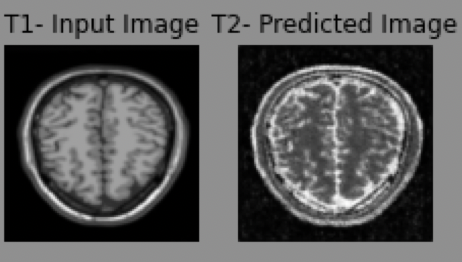

</center>

<center>Conversion of T2 to T1</center>

<center>

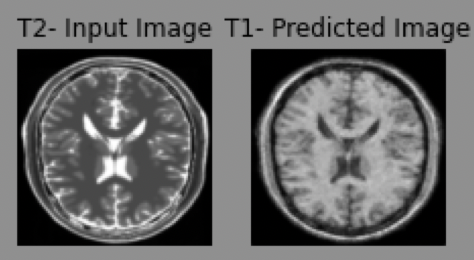
</center>

### Pipeline
The Sequence of the Project

1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

In [1]:
# required if you are running the file from google drive.
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/My Drive/Capstone')
os.chdir(str(base_dir))

Mounted at /content/gdrive


### Import Libraries

Versions of Libraries -

1.   numpy - 1.19.2
2.   tensorflow - 2.4.1
3.   matplotlib - 3.3.2
4.   skimage - 0.17.2







In [2]:
# required to embed the images into a gif in the later steps
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mj2qtb8d
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-mj2qtb8d
  Resolved https://github.com/tensorflow/docs to commit cc23491973e235ec68b93588a00ae9f4fe3d62a1
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=5a432a1448b7e5ab54e3ab278eb380e63bb72a1534c686a1177bf7169f03eca7
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkfnfemi/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob
import cv2
import os
from IPython.display import Markdown as md
import tensorflow_docs.vis.embed as embed
from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Data Loading

Define all the constants here that will be used in this notebook

In [4]:
#Used only for reporting purpose in the graphs
domain1_title = "T1"
domain2_title = "T2"
# experimented with 8, 16 and 32 and finalized 8 after
# reviewing the parameters and the final results
batch_size = 8 

#Ran this notebook for 250 epochs and after reviewing the 
# loss function plot, 128 epochs are sufficient to generate
# required model
epochs = 128

#Original image is 211 x 181
# Tried with 256 x 256 but that requires more trainable parameters
# 128 x 128 was giving similar results with better performance model.
# In this instance even though the output image quality is of utmost importance
# 128 x 128 is sufficient to achieve that quality
image_height = 128
image_width = 128

#Images are gray scale so setting the channels to be 1
num_channels=1

In [5]:
class DataUtils():
  def __init__(self,source_path, resize):
        '''
        :Description : Data utility to perform required preprocessing
        :param sourcePath: File path to data source
        :param resize: new size that images need to be resized to
        '''
        self.data = None
        self.source_path = source_path
        self.resize = resize
        self.image_size = None
        #self.prepare_data()
  
  def load_data(self):
        '''
        :Description : load all the image files into dataset
        :return: the list of data elements in the form of numpy array
        '''
        self.read_image_files()
        return self.data

  def read_image_files(self):
        '''
        :Description: function to read the data files from the path specified 
        '''
        # check if the path is valid or not
        if os.path.isdir(self.source_path):
            self.data = [imageio.imread(os.path.join(self.source_path, f)) 
                        for f in os.listdir(self.source_path)
                        if f.endswith(('.jpeg', '.jpg', '.png'))]
            self.image_size = self.data[-1].shape
      
            if len(self.image_size) != len(self.resize):
                raise Exception("Size mismatch!!")
        else:
            raise Exception("Invalid path")

  def data_preprocess(self):
      '''
      :Description: function to preprocess the data
      :             like normalizing, reshape and resize 
      :return: the list of data elements in the form of numpy array 
               post data pre-processing
      '''
      # normalize the data between -1 to +1
      normalized_data = (np.asarray(self.data, dtype=np.float32) / 127.5) - 1
     
      # reshape if image_size is specified
      if len(self.image_size) == 2:
          self.resize = (self.resize[0], self.resize[1], 1)
          self.image_size = (self.image_size[0], self.image_size[1], 1)
          normalized_data.reshape((normalized_data.shape[0],self.image_size[0],self.image_size[1], self.image_size[2]))

      # resize the images
      final_shape = (normalized_data.shape[0], self.resize[0], self.resize[1], self.resize[2])
      self.data = np.zeros(final_shape, dtype=np.float32)
      for index, img in enumerate(normalized_data):
          self.data[index, :, :,:] = resize(img, self.resize)
      return self

  def get_data(self, batch_size):
      '''
      :Description: function to batch and shuffle the data. We are using seed as 42 for consistency
      :return: tensor flow dataset 
      '''
      return tf.data.Dataset.from_tensor_slices(self.data).shuffle(self.data.shape[0], seed=42).batch(batch_size)


In [6]:
class PlotUtils():
  def __init__(self):
        '''
        :param None:
        '''
  def plot_img(self,img,title,axis='on'):
      '''
      :Description: function to plot an image
      '''
      plt.figure(figsize=(2,10))
      print(len(img.shape))
      # if the num of dimensions of image are 3, then consider 
      # image_width and image_height for plotting.
      if len(img.shape)==3:
        img_plot = img[:, :, 0]
      else:
        img_plot = img
      plt.imshow(img_plot,cmap='gray')
      plt.title(title)
      plt.axis(axis)

In [7]:
# Read the T1 images from the path below
path_domain1 = os.path.join(os.getcwd(),'Dataset','Tr1', 'TrainT1')
# Read the T2 images from the path below
path_domain2 = os.path.join(os.getcwd(),'Dataset', 'Tr2', 'TrainT2')

#Create the DataUtil objects for T1 and T2 image datasets
domain1 = DataUtils(path_domain1, (image_height,image_width))
domain2 = DataUtils(path_domain2, (image_height,image_width))

# load images from the path
images_domain1 = domain1.load_data()
images_domain2 = domain2.load_data()

#### Data Visualization of Image containing DOMAIN1 and DOMAIN2

Total 43 Images of T1 with shape of 217 x 181

In [8]:
images_domain1[0].shape

(217, 181)

2


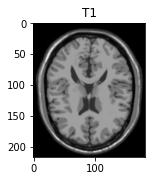

In [9]:
PlotUtils().plot_img(images_domain1[0],domain1_title)

Total 46 Images of T2 with image size of 217 x 181

2


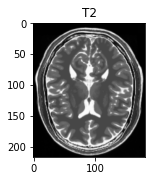

In [10]:
PlotUtils().plot_img(images_domain2[0],domain2_title)

### Data Preprocessing
1.   Data Resizing
2.   Data Reshaping
3.   Batch and Shuffle Data

### The following three steps are covered by the data_preprocessing method in DataUtil class. For implementation details please refer to DataUtil class.
#### - Resize images to size specified by image_height and image_width
#### - Reshape images to (image_height,image_width,num_channels) with float pixel values.
#### - Batch and shuffle the data.

In [11]:
domain1_data = domain1.data_preprocess().get_data(batch_size);
domain2_data = domain2.data_preprocess().get_data(batch_size);

3


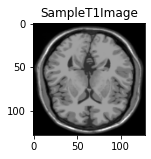

In [12]:
# read a sample image of T1 to display
sample_domain1_data = next(iter(domain1_data))
PlotUtils().plot_img(sample_domain1_data[0],"Sample" + domain1_title + "Image",axis='on')

3


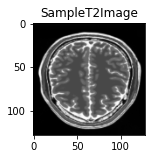

In [13]:
# read a sample image of T2 to display
sample_domain2_data = next(iter(domain2_data))
PlotUtils().plot_img(sample_domain2_data[0],"Sample" + domain2_title + "Image",axis='on')

### The above images of T1 and T2 train images are resized to 128 x 128 from 217 x 181. Also the reshaped, batched and shuffled

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

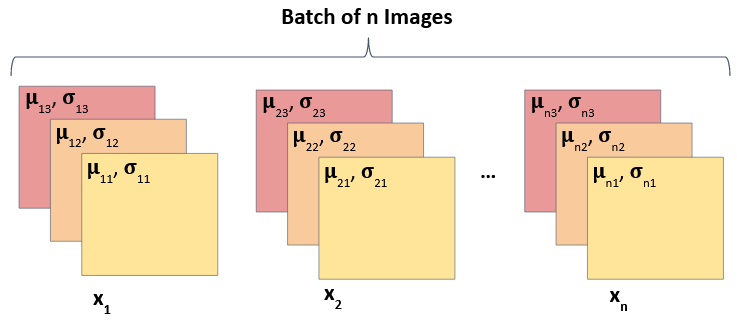

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduction in dimensions.

In [15]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>
Let's understand it through the below image.

<center>

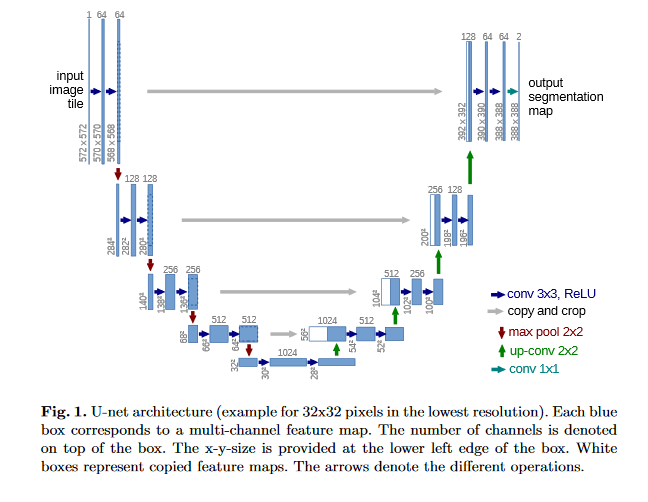

</center>

#### The following layers and features at each layer was finalized after experimenting with multiple iterations. As we wanted to capture all the important features as it's medical images and we dont' want to miss any tumour related features, we went for all layers. However this will increase the complexity of the model leading to overfitting problem. Hence we have made use of drop outs, skip connections to avoid the overfitting problem.

We input matrix (encoder) of 128 x 128 -> row vector (1 x 1 x 512) -> output matrix (decoder) of 128 x 128
      

In [17]:
def unet_generator():
    down_stack = [
        downsample(64, 4,False), # (bs, 64, 64, 64) -
        downsample(64, 4), # (bs, 32, 32, 64) -
        downsample(128, 4), # (bs, 16, 16, 128) -
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(256, 4), # (bs, 4, 4, 256)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4) # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4,True), # (bs, 2, 2, 512)
        upsample(256, 4,True), # (bs, 4, 4, 256)
        upsample(256, 4), # (bs, 8, 8, 256)
        upsample(128, 4,True),# (bs, 16, 16, 128)
        upsample(128, 4), # (bs, 32, 32, 128) --
        upsample(64, 4), # (bs, 64, 64, 64) --
        upsample(64, 4) # (bs, 128, 128, 64) --
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[image_height, image_width, num_channels])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of Image (digit 4) into Another type of Image (digit 9).

In [18]:
generator_g = unet_generator()
generator_f = unet_generator()

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

Notice How the dimension reduces first but then increases.

In [19]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   1024        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 64)   65664       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 128)  131328      ['sequential_1[0][0]']       

#### Discriminator
Discriminator is a traditional CNN, which we use to classify the Images. It only uses Downsampling hence.

Both Discriminators have same architecture

In [20]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[image_height, image_width, num_channels], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128,4)(down1) # (bs,64,164,128) --
    down3 = downsample(128,4)(down2) # (bs,32,32,128) --
    down4 = downsample(256,4)(down3) # (bs,16,16,256) --
    #down5 = downsample(256, 4)(down4) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(image_height, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7,image_height)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, image_height)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [21]:
discriminator_x = discriminator()
discriminator_y = discriminator()

Have a look at Discriminator's architecture, Notice that The Dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.

In [22]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_28 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_29 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_30 (Sequential)  (None, 16, 16, 128)       262400    
                                                                 
 sequential_31 (Sequential)  (None, 8, 8, 256)         524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 10, 10, 256)      0         
 2D)                                                             
                                                           

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

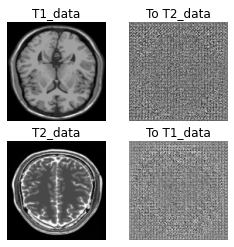

In [23]:
to_domain2_data = generator_g(sample_domain1_data)
to_domain1_data = generator_f(sample_domain2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_domain1_data, to_domain2_data, sample_domain2_data, to_domain1_data]
title = [domain1_title + "_data", "To "+ domain2_title + "_data", domain2_title+"_data", "To "+ domain1_title + "_data"]

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [24]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [25]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [26]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

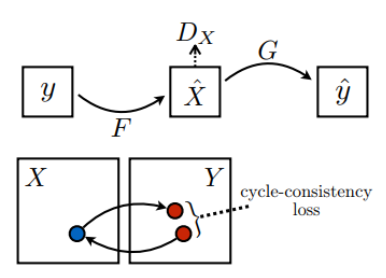

In [27]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

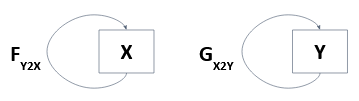

In [28]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [29]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoint Initialization
Initialize checkpoints to save models

In [30]:
checkpoint_path = "./Trained_Model"
epoch_images_dir = checkpoint_path+'/images/'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [31]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    regenerated1 = model2(prediction1)
    prediction2 = model2(test_input2)
    regenerated2 = model1(prediction2)
    plt.figure(figsize=(12, 24))
    display_list = [test_input1[0], prediction1[0],regenerated1[0], test_input2[0], prediction2[0],regenerated2[0]]
    title = [domain1_title +'- Input Image', 
             domain2_title +'- Predicted Image', 
             domain1_title + '- Regen Image',
             domain2_title + '- Input Image', 
             domain1_title + '- Predicted Image',
             domain2_title + '- Regen Image']
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')
    if not os.path.isdir(epoch_images_dir):
      os.makedirs(epoch_images_dir)
    plt.savefig(epoch_images_dir +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Training FLow
Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [32]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X-> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
      
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss,disc_x_loss, disc_y_loss

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

In [33]:
# We can plot the images afer each epoch
# also capture the losses from 2 generators and 2 discriminators
g_hist, f_hist, dg_hist, df_hist = list(), list(), list(), list()
for epoch in range(1, epochs + 1):
    for image_x, image_y in tf.data.Dataset.zip((domain1_data, domain2_data)):
        total_gen_g_loss, total_gen_f_loss,disc_x_loss, disc_y_loss = train_step(image_x, image_y)
    g_hist.append(total_gen_g_loss)
    f_hist.append(total_gen_f_loss)
    dg_hist.append(disc_x_loss)
    df_hist.append(disc_y_loss)
    generate_images(generator_g, sample_domain1_data, generator_f, sample_domain2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

Output hidden; open in https://colab.research.google.com to view.

#### Let us plot the losses for 2 generators and 2 discriminators

In [34]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

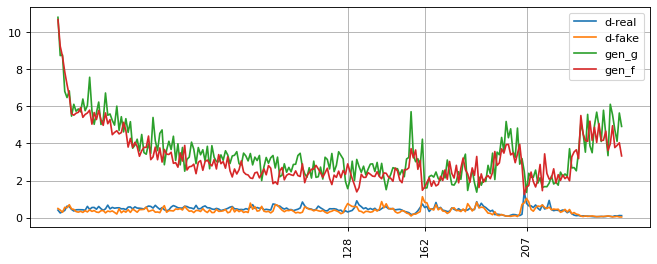

In [87]:
figure(figsize=(10, 8), dpi=80)
pyplot.subplot(2, 1, 1)
pyplot.grid()
plt.xticks(rotation=90)
plt.xticks([128,162,207]) 
pyplot.plot(dg_hist, label='d-real')
pyplot.plot(df_hist, label='d-fake')
pyplot.plot(g_hist, label='gen_g')
pyplot.plot(f_hist, label='gen_f')
pyplot.legend()

As observed from the above plot, the generator losses are coming down around 128 but then again the discriminator grows stronger and the losses from the generator tends to increase. 

The same pattern repeats at 162 and 207 as well. If we continue beyond 250 epochs, the losses might come down again but by then the generator would start memorizing the data and would lead to overfitting.

In order to check if the models that were saved / generated at epochs 128, 162, 207 and final one 250 performs

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [71]:
class GifUtil():
  def create_gif(self,path_images,gif_anim_file_name):
    with imageio.get_writer(gif_anim_file_name, mode='I') as writer:
      filenames = glob.glob(path_images)
      filenames = sorted(filenames)
      for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [72]:
anim_file = 'cyclegan.gif'
images_path = './Trained_Model/images/image*.png'
GifUtil().create_gif(images_path,anim_file)
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

## Let us check how various models generated at various checkpoints / epochs perform.

PS:- Due to size restriction, the checkpoints and models are uploaded to the git hub repo. Please click here to access the git hub repo to download the checkpoints         
https://github.com/chandamouli/CycleGAN_MRI_T1_T2

In [80]:
def predict():
    '''
    :Description: This function checks the prediction of images downloaded from the 
                  internet to see how the model performs on unseen data
                  T1_1.png and T2_1.png are both paired images that will act as 
                  test images
    '''
    image = tf.io.read_file('./Test_Images/T1_1.png')
    image_t2_original = tf.io.read_file('./Test_Images/T2_1.png')
    image = tf.image.decode_jpeg(image, channels=num_channels)
    # Resize images to a common size of 128 x 128
    image = tf.image.resize(image, [image_height, image_width])
    image = image * 1.0/127.5 - 1.0
    reshaped_image = tf.reshape(image, [-1,image_height, image_width,num_channels])

    image_t2_original = tf.image.decode_jpeg(image_t2_original, channels=1)
    image_t2_original =  tf.image.resize(image_t2_original, [image_height, image_width])
    image_t2_original = image_t2_original * 1.0/127.5 - 1.0
    image_t2_original = tf.reshape(image_t2_original, [-1,image_height, image_width,num_channels])

    image_tar = generator_g.predict(reshaped_image)
    image_tar1 = generator_f.predict(image_t2_original)
    plt.subplot(1, 4,1)
    plt.title('T1 - Original')
    pyplot.imshow(reshaped_image[0][:,:,0], cmap='gray')
    plt.subplot(1, 4,2)
    plt.title('T2 - Predicted')
    pyplot.imshow(image_tar[0][:,:,0],cmap='gray')
    plt.subplot(1, 4,3)
    plt.title('T2 - Original')
    pyplot.imshow(image_t2_original[0][:,:,0],cmap='gray')
    plt.subplot(1, 4,4)
    plt.title('T1 - Predicted')
    pyplot.imshow(image_tar1[0][:,:,0],cmap='gray')
    pyplot.show()

In [81]:
def load_checkpoint(checkpoint_num):
    '''
    :Description: This function loads the weights and biases for the 
                  specified model using checkpoint_num parameter
    :param checkpoint_num: checkpoint_num saved in the /Mymodel folder
                            e.g. 128, 131
    '''
    checkpoint_path = "./Mymodel/"+checkpoint_num

    ckpt = tf.train.Checkpoint(generator_g=generator_g,
                              generator_f=generator_f,
                              discriminator_x=discriminator_x,
                              discriminator_y=discriminator_y,
                              generator_g_optimizer=generator_g_optimizer,
                              generator_f_optimizer=generator_f_optimizer,
                              discriminator_x_optimizer=discriminator_x_optimizer,
                              discriminator_y_optimizer=discriminator_y_optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)
    status = ckpt.restore(checkpoint_path)
    status.assert_consumed()

1/1 [==============================] - 0s 52ms/step


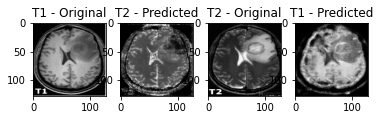

In [82]:
# using the latest model i.e. 250
predict() 

1/1 [==============================] - 0s 53ms/step


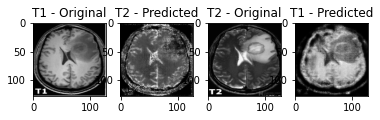

In [83]:
# predict using the model 128
load_checkpoint("ckpt-128")
predict()

1/1 [==============================] - 0s 56ms/step


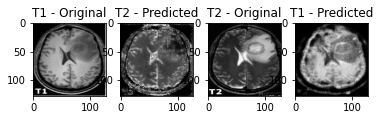

In [89]:
# predict using the model 162
load_checkpoint("ckpt-162")
predict()

1/1 [==============================] - 0s 55ms/step


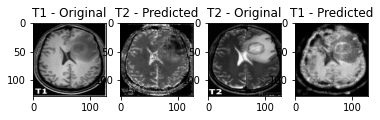

In [85]:
# predict using the model 207
load_checkpoint("ckpt-207")
predict()

## **Conclusion**: Model 128, 161, 207 or 250 doesn't show too much of variance in the predicted output. Hence we can conclude that model 128 can be used for further predictions.

Note: Due to time constraint for this project timelines, we are stopping here. The model can further be fine tuned to generate better images and also with other architectures like half-net etc...